In [1]:
% matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

In [2]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

df = pd.read_csv('Projects/ums_viz.csv')
df_perf = pd.read_pickle('Projects/descriptions.pkl')
df_perf.columns.values[0] = 'perf_name'

df['perf_name'] = df['perf_name'].apply(lambda x: x.strip())
df_perf['perf_name'] = df_perf['perf_name'].apply(lambda x: x.strip())

df['per_seat'] = df['tck_amt']/df['num_seats']
df_group = df.groupby('perf_name')

# proportion of student tickets
df['sprop'] = df['price_type_group'] == 'Student Prices'
df_group = df.groupby('perf_name')

In [3]:
# Add a whole bunch of new performance-level features

# mean ticket amount, number of seats, price per seat
df_tmp = df_group['tck_amt', 'num_seats', 'per_seat'].mean().reset_index()
df_tmp = df_tmp.rename(columns = {'tck_amt': 'mean_tck_amt', 'num_seats': 'mean_num_seats', 'per_seat': 'mean_per_seat'})

df_perf = pd.merge(df_perf, df_tmp, on='perf_name')

# max ticket amount, number of seats, price per seat
df_tmp = df_group['tck_amt', 'num_seats', 'per_seat'].max().reset_index()
df_tmp = df_tmp.rename(columns = {'tck_amt': 'max_tck_amt', 'num_seats': 'max_num_seats', 'per_seat': 'max_per_seat'})
df_perf = pd.merge(df_perf, df_tmp, on='perf_name')

# total number of seats
df_tmp = df_group['num_seats'].count().reset_index()
df_tmp = df_tmp.rename(columns = {'num_seats': 'count_tck_amt'})
df_perf = pd.merge(df_perf, df_tmp, on='perf_name')

# proportion of student tickets
df_tmp = df_group['sprop'].mean().reset_index()
df_tmp = df_tmp.rename(columns = {'sprop': 'sprop'})
df_perf = pd.merge(df_perf, df_tmp, on='perf_name')
df_perf['sprop'] = pd.to_numeric(df_perf['sprop'], errors='coerce')

print df_perf.head()

              perf_name                                        description  \
0   The Infernal Comedy  John Malkovich makes his UMS debut portraying ...   
1      Yuja Wang, piano  Chinese pianist Yuja Wang combines the spontan...   
2   London Philharmonic  The London Philharmonic returns for its first ...   
3      Hamburg Symphony  In 1971, French composer Olivier Messiaen was ...   
4  Chicago Symphony Orc  The Chicago Symphony Orchestra is consistently...   

   mean_tck_amt  mean_num_seats  mean_per_seat  max_tck_amt  max_num_seats  \
0     72.092196        1.997354      37.194444        595.0             14   
1     63.171001        2.003096      32.884830        460.0             23   
2     77.771242        1.937255      40.968301       1000.0             50   
3     62.176976        1.838933      34.027619        487.5             17   
4    110.584576        1.914630      56.604253      14960.0            187   

   max_per_seat  count_tck_amt     sprop  
0          75.0    

In [19]:
# Extract bigram matrix
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1, 3), max_df=.7, min_df=.2, stop_words = 'english', tokenizer=tokenize_only)
X = vect.fit_transform(df_perf.description.values)

print X.shape

# Latent Dirichlet Allocation
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_topics=5, max_iter=100, random_state=0)
y = lda.fit_transform(X)

(143, 72)


In [20]:
# MDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

dist = 1 - cosine_similarity(y)

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
pos = mds.fit_transform(dist)
xs, ys = pos[:,0], pos[:,1]

In [21]:
words_by_topic = []

def print_top_words(model, feature_names, n_top_words, words_by_topic):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        words = ' '.join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])
        words_by_topic.append(words)
        print(words)
    print
    
print_top_words(lda, vect.get_feature_names(), 20, words_by_topic)
words_by_topic = [i.split(' ') for i in words_by_topic]

df_perf['topic'] = np.argmax(y, 1)
#df_perf.groupby('topic').describe()

Topic #0:
mr. jazz album york new york musical best released including debut international recording performed composer contemporary concert ensemble recent live dance
Topic #1:
orchestra symphony concert musical world group years concerts chamber europe including american performed tour works musicians perform recordings major grammy
Topic #2:
dance center works national artistic repertoire contemporary arts director program performances years american audiences classical performed tour festival ums work
Topic #3:
theatre national ums theater london director work tour world time audiences life hall performance stage live including years musical performances
Topic #4:
festival debut international ensemble hall award artists season classical great performance arts include ums london recording work performances university world



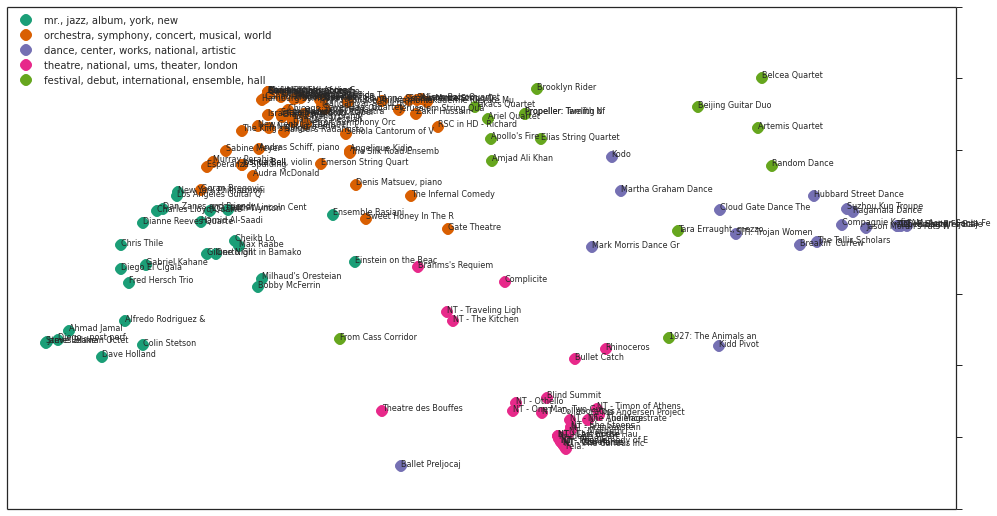

In [23]:
# visualize clusters
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
cluster_names = {0: ', '.join(words_by_topic[0][:5]),
                 1: ', '.join(words_by_topic[1][:5]),
                 2: ', '.join(words_by_topic[2][:5]),
                 3: ', '.join(words_by_topic[3][:5]),
                 4: ', '.join(words_by_topic[4][:5])}
df2 = pd.DataFrame(dict(x=xs, y=ys, label=df_perf['topic'].tolist(), perf=df_perf['perf_name']))
groups = df2.groupby('label')

fig, ax = plt.subplots(figsize=(17,9))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis='y', which='both', left='off', top='off', labelleft='off')

ax.legend(loc='upper left', numpoints=1, fontsize='small')

for i in range(len(df2)):
    ax.text(df2.ix[i]['x'], df2.ix[i]['y'], df2.ix[i]['perf'], size=8)

plt.savefig('Projects/lda_viz.png', dpi=200)
plt.show()

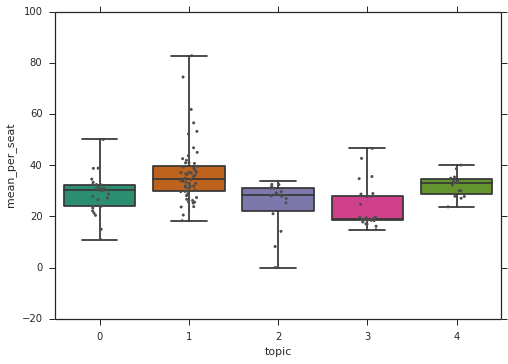

In [24]:
import seaborn as sns
topic_range = range(5)
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

sns.set(style="ticks", palette="muted", color_codes=True)
ax = sns.boxplot(x="topic", y="mean_per_seat", data=df_perf, whis=np.inf, palette=cluster_colors, order=topic_range)
sns.stripplot(x="topic", y="mean_per_seat", data=df_perf, jitter=True, size=3, color=".3", linewidth=0, order=topic_range)
plt.show()

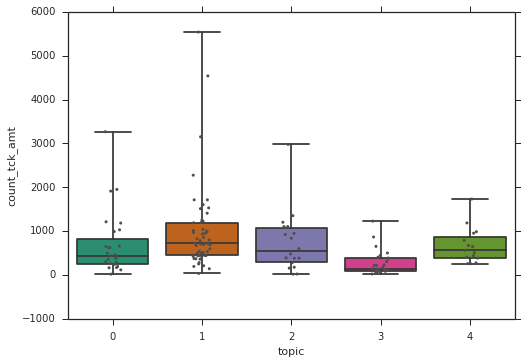

In [25]:
sns.set(style="ticks", palette="muted", color_codes=True)
ax = sns.boxplot(x="topic", y="count_tck_amt", data=df_perf, whis=np.inf, palette=cluster_colors, order=topic_range)
sns.stripplot(x="topic", y="count_tck_amt", data=df_perf, jitter=True, size=3, color=".3", linewidth=0, order=topic_range)
plt.show()

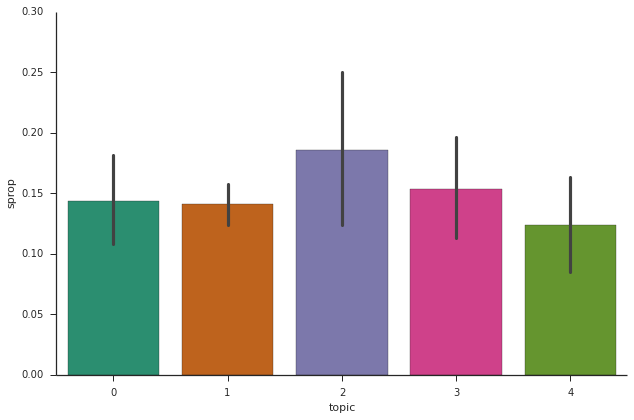

In [27]:
sns.factorplot(x='topic', y='sprop', data=df_perf, kind='bar', palette=cluster_colors, size=6, aspect=1.5, order=topic_range)
plt.ylim(0, .3)
plt.show()